<a href="https://colab.research.google.com/github/ChemAI-Lab/QSciTech-QuantumBC-CMC-2025/blob/main/notebooks/MeasurementOptTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This cell you will need to run it twice (First time will crash)
!pip install numpy==1.26.4
!pip install jax==0.4.28 jaxlib==0.4.28
import numpy as np
print(np.__version__)
if int(np.__version__[0]) > 1:
  import os
  os.kill(os.getpid(), 9)

!pip install typing-extensions --upgrade
!pip install pennylane update
!pip install tqdm
!pip install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion
!pip install --upgrade git+https://github.com/aspuru-guzik-group/tequila.git@devel
!pip install PySCF

1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 111.6 MB/s eta 0:00:00
  Cloning https://github.com/quantumlib/OpenFermion.git (to revision master) to /tmp/pip-install-ogko65ba/openfermion_b28ad66aae5947ffa50dd09908067936
  Running command git clone --filter=blob:none --quiet https://github.com/quantumlib/OpenFermion.git /tmp/pip-install-ogko65ba/openfermion_b28ad66aae5947ffa50dd09908067936
  Resolved https://github.com/quantumlib/OpenFermion.git to commit 9423933ed05a150f9681e9a1e9cac40e29c81ead
  Installin

In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from tqdm import tqdm, trange
from openfermion.transforms import *
from openfermion.ops import FermionOperator, QubitOperator, BinaryCode, BinaryPolynomial
import tequila as tq
from tequila.hamiltonian import QubitHamiltonian, paulis
from tequila.grouping.binary_rep import BinaryHamiltonian
from tequila.grouping import *
import networkx as nx
from networkx import Graph
import numpy as np
from openfermion.linalg import get_ground_state, get_sparse_operator, variance
from openfermion.utils import count_qubits
import math
from jax import random
from jax import numpy as jnp
from collections import defaultdict


In [3]:
def H2():
    '''
    H2 hamiltonian for minimal basis.
    '''
    trafo = "JordanWigner"
    mol = tq.chemistry.Molecule(
                            geometry="H 0.0 0.0 0.0 \n H 0.0 0.0 1.0",
                            basis_set="sto3g",
                            transformation=trafo,
                            backend='pyscf'
                                 )
    H = mol.make_hamiltonian()
    Hq = H.to_openfermion()
    Hferm = reverse_jordan_wigner(Hq)
    n_paulis = len(Hq.terms) - 1 #Minus 1 since it always contain a constant term that we don't need to measure.
    return mol, H, Hferm, n_paulis, Hq

#Measurement problem and measurement optimization

The measurement problem arises due to the large number of measurements required in order to achieve a small enough variance/error on our expectation values. We can't measure everything together so we need to partition the Hamiltonian in compatible fragments.
\begin{equation}
\hat{H}_q=\sum_{\alpha=1}^{N_f}\hat{H}_\alpha; \ \ \ \  E_\theta = \sum_{\alpha=1}^{N_f}\langle\psi_\theta|\hat{H}_\alpha|\psi_\theta\rangle.
\end{equation}

To generate each group we will use fully commuting (FC) groupings where the overall commutator between operators is 0 and qubit-wise commuting  (QWC) where the operators need to commute at each qubit.
For example $X_0X_1$ and $Y_0Y_1$ commute but they don't qubit-wise commute.

For each group, one can find Unitary operators that diagonalizes it
\begin{split}
&U_\alpha\hat{H}_\alpha U_\alpha^\dagger = p(\hat{z}_i)\\
&\langle\psi|\hat{H}_\alpha|\psi\rangle= \langle\psi|U_\alpha^\dagger U_\alpha \hat{H}_\alpha U_\alpha^\dagger U_\alpha|\psi\rangle = \langle\psi|U_\alpha^\dagger p(\hat{z}_i) U_\alpha|\psi\rangle
\end{split}
This means that we only need to implement the unitary to get the quantunm circuit. QWC groups require only single-qubit operators while FC groupings require multiqubit operations. See: [arXiv:1907.09386](https://arxiv.org/abs/1907.09386)

Let's see how these groupings compare in terms of measurements.
The number of measurements is given by
\begin{split}
M=\frac{1}{\varepsilon^2}\left(\sum_\alpha^{N_f}\sqrt{\text{Var}(\hat{H}_\alpha)}\right)^2 \\
M \approx \frac{\left ( \sum_i \sqrt{\sum_j c_{ij}^2} \right )^2}{\epsilon^2}
\end{split}
[arXiv:2201.01471v3](https://arxiv.org/abs/2201.01471v3)  
[Phys. Rev. Research 4, 033154, 2022](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.033154)

We will also need **OpenFermion** and **Tequila** to get through this.
https://github.com/tequilahub/tequila

In [4]:
mol, H, Hferm, n_paulis, Hq = H2()

H = qml.qchem.import_operator(Hq)
H_coeffs, H_ops = H.terms()
print(H)
m = qml.resource.estimate_shots(H_coeffs)
print(f'Estimated Shots w/o grouping : {m}')

-0.3276081896748094 * I(0) + 0.13716572937099508 * Z(0) + 0.13716572937099514 * Z(1) + -0.13036292057109108 * Z(2) + -0.13036292057109108 * Z(3) + 0.1566006248823795 * (Z(0) @ Z(1)) + 0.04919764587136754 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04919764587136754 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04919764587136754 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04919764587136754 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.10622904490856078 * (Z(0) @ Z(2)) + 0.15542669077992832 * (Z(0) @ Z(3)) + 0.15542669077992832 * (Z(1) @ Z(2)) + 0.10622904490856078 * (Z(1) @ Z(3)) + 0.16326768673564337 * (Z(2) @ Z(3))
Estimated Shots w/o grouping : 1414072


In [5]:
ops, coeffs = qml.pauli.group_observables(H_ops, H_coeffs, 'qwc', 'rlf')
c_qwc = [np.array(c) for c in coeffs] # cast as numpy array
m = qml.resource.estimate_shots(c_qwc)
print(f'Shots grouped by PennyLane RLF QWC: {m}')#This is just an estimate!!

Shots grouped by PennyLane RLF QWC: 329884


In [6]:
ops, coeffs = qml.pauli.group_observables(H_ops, H_coeffs, 'commuting', 'rlf')
c_fc = [np.array(c) for c in coeffs] # cast as numpy array
m = qml.resource.estimate_shots(c_fc)
print(f'Shots grouped by PennyLane RLF FC: {m}')#This is just an estimate!!

Shots grouped by PennyLane RLF FC: 163539


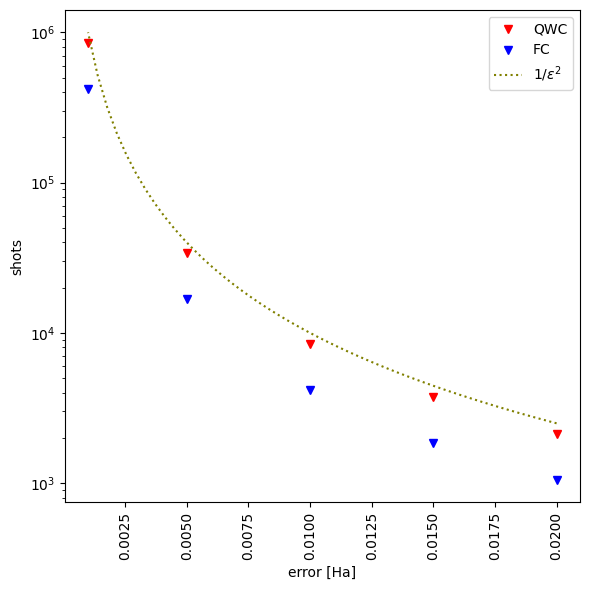

In [7]:
error = np.array([0.02, 0.015, 0.01, 0.005, 0.001])
m_qwc = [qml.resource.estimate_shots(c_qwc, error=er) for er in error]
m_fc = [qml.resource.estimate_shots(c_fc, error=er) for er in error]

e_ = np.linspace(error[0], error[-1], num=50)
m_ = 1.0 / np.linspace(error[0], error[-1], num=50)**2

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(error, m_qwc, 'v', color='red', label='QWC')
ax.plot(error, m_fc, 'v', color='blue', label='FC')

ax.plot(e_, m_, ':', markerfacecolor='none', color='olive', label='$ 1/\epsilon^2 $')

ax.set_ylabel('shots')
ax.set_xlabel('error [Ha]')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation = 90)
ax.legend()
fig.tight_layout()

There are other approaches to grouping.  

We will explore a generative model called **[GFlowNets](https://arxiv.org/abs/2111.09266)** and use **[Tequila](https://github.com/tequilahub/tequila)** which has better implementations which require variance estimators.
**GFlowNets for grouping (Us): [arXiv:2410.16041](https://arxiv.org/abs/2410.16041v1)**

In [8]:
from openfermion.transforms import *
from openfermion.ops import FermionOperator, QubitOperator, BinaryCode, BinaryPolynomial
import tequila as tq
from tequila.hamiltonian import QubitHamiltonian, paulis
from tequila.grouping.binary_rep import BinaryHamiltonian
from tequila.grouping import *
import networkx as nx
from networkx import Graph
import numpy as np
from openfermion.linalg import get_ground_state, get_sparse_operator, variance
from openfermion.utils import count_qubits
import math
from jax import random
from jax import numpy as jnp
from collections import defaultdict

#Functions to generate the Hamiltonian and Complementary Graphs

In [9]:
def get_terms(bin_H):
    """ Gets the terms from a Binary Hamiltonian excluding the constant term"""
    terms=[]
    for i in range(1,len(bin_H.binary_terms)):
        terms.append(bin_H.binary_terms[i])
    return terms

def FC_CompMatrix(terms):
    """ Generates the Fully commuting complementary matrix"""
    FC_CompMatrix=[]
    rows=len(terms)
    cols=len(terms)
    FC_CompMatrix = [[0 for _ in range(cols)] for _ in range(rows)]
    for i in range(rows):
        for j in range(cols):
            if terms[i].commute(terms[j]):
                FC_CompMatrix[i][j]=1
                FC_CompMatrix[j][j]=1 #Avoids self loops
            else:
                FC_CompMatrix[i][j]=0
    return FC_CompMatrix

def QWC_CompMatrix(terms):
    """ Generates the Qubit-wise commuting complementary matrix"""
    QWC_CompMatrix=[]
    rows=len(terms)
    cols=len(terms)
    QWC_CompMatrix = [[0 for _ in range(cols)] for _ in range(rows)]
    for i in range(rows):
        for j in range(cols):
            if terms[i].qubit_wise_commute(terms[j]):
                QWC_CompMatrix[i][j]=1
                QWC_CompMatrix[j][j]=1 #Avoids self loops
            else:
                QWC_CompMatrix[i][j]=0
    return QWC_CompMatrix

def obj_to_comp_graph(terms, matrix) -> Graph:
        """Convert terms from a compCommMatrix to a Graph"""
        g = nx.Graph()
        matrix = matrix  # Make a copy
        terms = terms
        for a in range(len(terms)):
            g.add_node(
                a,
                v=terms[a].to_pauli_strings(),
            )
        for i in range(len(terms)):
            for j in range(i,len(terms)):
                if matrix[i][j] == 0:
                    g.add_edge(
                    i,
                    j,
                )
        return g

#Functions for getting measurements from Graphs

In [10]:
def extract_hamiltonian_by_color(graph):
    """
    Extracts the hamiltonian groups based on the coloring of the graph.
    """
    hamiltonian_terms = defaultdict(list)

    for node, data in graph.nodes(data=True):
        color = data['color']
        pauli_string = data['v']
        #print(type(pauli_string))
        hamiltonian_terms[color].append(pauli_string)

    return dict(hamiltonian_terms)

def generate_groups(hamiltonian_by_color):
    """
    This generates the groups from a colored Hamiltonian in an openfermion format
    """
    groups = []

    for color, pauli_strings in hamiltonian_by_color.items():
        # Create a QubitHamiltonian from the PauliString list
        qubit_hamiltonian = QubitHamiltonian.from_paulistrings(pauli_strings)
        # Convert to OpenFermion QubitOperator
        openfermion_operator = qubit_hamiltonian.to_openfermion()
        # Append to the groups list
        groups.append(openfermion_operator)

    return groups

def convert_operators(groups):
    """In the current implementation we need to convert operator to Pennylane
    to estimate the total number of shots. """
    imported_operators = []

    for hamiltonian in groups:
        # Import the QubitOperator into PennyLane format
        operator = qml.import_operator(hamiltonian, format='openfermion')
        imported_operators.append(operator)

    return imported_operators

def estimate_shots(imported_operators):
    """
    Estimate the number of shots required based on a list of imported PennyLane operators.

    Parameters:
    - imported_operators (list of qml.PauliSum): List of PennyLane operators.

    Returns:
    - list of float: Estimated number of shots for each operator.
    """
    # Initialize list to hold estimated shots for each operator
    estimated_shots_list = []
    all_coeffs = []
    # Iterate over each imported operator
    for operator in imported_operators:
        # Extract coefficients and observables from each operator
        coeffs, ops = operator.terms()

        # Convert coefficients to numpy arrays for compatibility with PennyLane
        all_coeffs.append(np.array(coeffs))

    #print(all_coeffs)
    # Estimate shots for the grouping
    estimated_shots = qml.resource.estimate_shots(all_coeffs)

    return estimated_shots

def shots_estimator(graph):
    """
    Full function that estimates the required number of shots to achieve chemical accuracy.
    Classifies the H by color, generates groups, translates to pennylane and estimates shots
    """
    h_by_color = extract_hamiltonian_by_color(graph)
    groups = generate_groups(h_by_color)
    imported_operators = convert_operators(groups)
    estimated_shots = estimate_shots(imported_operators)
    return estimated_shots

#Grouping with a generative model. GFlowNets

 GFlowNets learns the flow between different states in a compositional object. Effectively, we are learning the probability to reach a terminal state and make that probability proportional to a reward function $P_\mathcal{T}(s)\propto R(s)$. The model will learn the flow between states! The probability to have a state is: $P(x) = \sum_{s\in\mathcal{T}_x}F(s)/Z$

 We are considering Markovian Flows meaning that for a given trajectory $\tau=(s_0\rightarrow s_1\rightarrow\dots s_{n-1}\rightarrow s_n)$ we need that:

 \begin{equation}
 \prod_{t=1}^nP_{F,\theta}(s_t|s_{t-1})=\frac{F(s_n)}{Z_\theta}\prod_{t=1}^nP_{B,\theta}(s_{t-1}|s_t)
 \end{equation}
For a terminal state we replace the flow with the reward and we will rearrange a bit to later construct our Loss function
\begin{equation}
 Z_\theta\prod_{t=1}^nP_{F,\theta}(s_t|s_{t-1})=R(s_n)\prod_{t=1}^nP_{B,\theta}(s_{t-1}|s_t)
 \end{equation}

In [11]:
mol, H, Hferm, n_paulis, Hq = H2()
print("Number of Pauli products to measure: {}".format(n_paulis))

sparse_hamiltonian = get_sparse_operator(Hq)
energy, fci_wfn = get_ground_state(sparse_hamiltonian)
print("Energy={}".format(energy))
n_q = count_qubits(Hq)
print("Number of Qubits={}".format(n_q))
#Get list of Hamiltonian terms and generate complementary graph
binary_H = BinaryHamiltonian.init_from_qubit_hamiltonian(H)
terms=get_terms(binary_H)
#CompMatrix=FC_CompMatrix(terms)
CompMatrix=QWC_CompMatrix(terms)
Gc=obj_to_comp_graph(terms, CompMatrix)
n_terms=nx.number_of_nodes(Gc)
print("Number of terms in the graph: {}".format(n_terms))


Number of Pauli products to measure: 14
Energy=-1.1011503302326187
Number of Qubits=4
Number of terms in the graph: 14


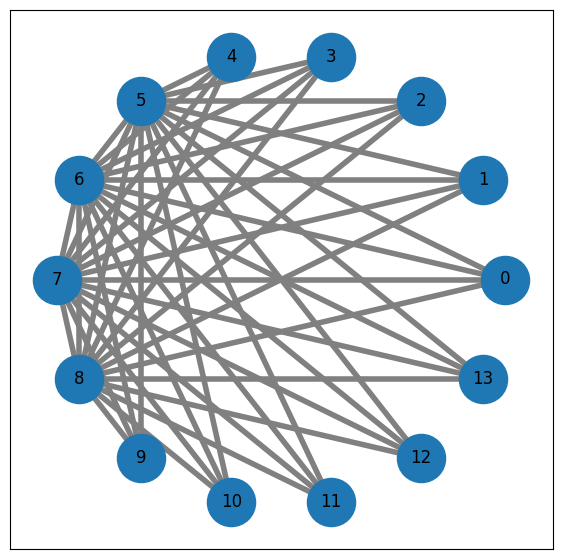

In [12]:
pos = nx.circular_layout(Gc)
options = {
    "pos": pos,
    "node_size": 1200,
    "edge_color": "gray",
    "alpha": 1,
    "width": 4,
    "labels": {n: n for n in Gc}
}
plt.figure(1,figsize=(7,7))
nx.draw_networkx(Gc,**options)

## Grouping with GFlowNets

For GFlowNets, we require a NN model to learn the flows. We will employ a **Reward function** ($R(x)$) based on reducing the number of colors and the number of measurements required:
\begin{equation}
    R(x)=\left( N_P-\text{max}\_\text{color}(x)\right) + \frac{\lambda_{0}}{M_{est}(x)}
\end{equation}

Here we will use the **Trajectory Balance** condition for the Loss.

\begin{equation}
    \mathcal{L}_{TB}(\tau)=\left(\log\frac{Z_\theta\prod_{t=1}^nP_{F,\theta}(s_t|s_{t-1})}{R(s_n)\prod_{t=1}^nP_{B,\theta}(s_{t-1}|s_t)} \right)^2
\end{equation}

In [13]:
from tqdm import tqdm, trange
from torch.distributions.categorical import Categorical
import torch
import torch.nn as nn
import random

#Functions for GFlowNets

Define the Model, Masking functions and the loss function.

In [14]:
class TBModel(nn.Module):
  def __init__(self, num_hid, n_terms):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(n_terms, num_hid),  # layers (Number of Paulis) input features.
        nn.LeakyReLU(),
        nn.Linear(num_hid, 2*n_terms),  # double outputs: 1/2 for P_F and 1/2 for P_B.
    )
    self.logZ = nn.Parameter(torch.ones(1))  # log Z is just a single number.

  def forward(self, x, n_terms):
    logits = self.mlp(x)
    # Slice the logits into forward and backward policies.
    P_F = logits[..., :n_terms]
    P_B = logits[..., n_terms:]

    return P_F, P_B

def calculate_forward_mask_from_state(state, t, lower_bound):
    """We want to mask the sampling to avoid any potential loss of time while training.
    In order to do so, we will have an upper bound on the number of colors used. Additionally,
    we can make the probability of using the same color in 2 neighbors = 0 to ensure validity.
    """
    layers=nx.number_of_nodes(state)
    mask = np.ones(layers)  # Allowed actions represented as 1, disallowed actions as 0.
    mask[lower_bound+1:] = 0
    neighbors = list(state.neighbors(t))
    neighbor_colors = [state.nodes[n]['color'] for n in neighbors]
    # Update the mask
    for color in neighbor_colors:
        mask[color] = 0
    return torch.Tensor(mask).bool()

def calculate_backward_mask_from_state(state,t,lower_bound):
    """Here, we mask backward actions to only select parent nodes."""
    # This mask should be 1 for any action that could have led to the current state,
    # otherwise it should be zero.
    layers=nx.number_of_nodes(state)
    mask = np.ones(layers)  # Allowed actions represented as 1, disallowed actions as 0.
    mask[lower_bound+1:] = 0
    neighbors = list(state.neighbors(t))
    neighbor_colors = [state.nodes[n]['color'] for n in neighbors]
    # Update the mask
    for color in neighbor_colors:
        mask[color] = 1
    return torch.Tensor(mask).bool()

def trajectory_balance_loss(logZ, log_P_F, log_P_B, reward):
    """Trajectory balance objective converted into mean squared error loss."""
    reward=torch.tensor(reward).float()
    return (logZ + log_P_F - torch.log(torch.clamp(reward, min=1e-30)) - log_P_B).pow(2)

Translate Graph to something trainable and with a reward.

In [15]:
def graph_hash(graph):
    """Returns a binary hash for each submitted graph."""
    if not nx.get_node_attributes(graph, "color"):
        # Assign a default color (-1) to all nodes
        nx.set_node_attributes(graph, -1, "color")

    colors_dict = nx.get_node_attributes(graph, "color")
    FEATURE_KEYS = list(colors_dict.values())

    return tuple(FEATURE_KEYS)

def graph_to_tensor(graph, verbose=False):
  """Encodes a graph as a binary tensor (converted to float32)."""
  if verbose:
      print("graph={}, hash={}, tensor={}".format(
          graph,
          graph_hash(graph),
          torch.tensor(graph_hash(graph)).float(),
          )
      )
  return torch.tensor(graph_hash(graph)).float()

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def is_not_valid(graph):
    """Checks whether the graph coloring is valid or not.
    Returns True if not valid, False if valid."""
    colors_dict = nx.get_node_attributes(graph, "color")
    colors_list = list(colors_dict.values())

    for i in range(nx.number_of_nodes(graph)):
        node_color = colors_list[i]
        # Check if any neighbor has the same color as the node
        same_color = any(node_color == colors_list[n] for n in graph.neighbors(i))

        # If any neighbor has the same color, the graph coloring is not valid
        if same_color:
            #print(f"Node {i} has the same color as at least one of its neighbors.")
            return True

    # If no conflicts were found, the graph coloring is valid
    #print("Graph coloring is valid. No neighboring nodes share the same color.")
    return False

def max_color(graph):
    colors_dict = nx.get_node_attributes(graph, "color")
    return len(set(colors_dict.values()))

def color_reward(graph):
  """Reward is based on the number of colors we have. The lower the better. Invalid configs give 0"""
  if is_not_valid(graph):
    return 0
  else:
    for i in range(nx.number_of_nodes(graph)+1):
        if max_color(graph) == i:
            return nx.number_of_nodes(graph)-i #Max number of colors - Actual max color of the graph.

def vqe_reward(graph):
    """Reward is based on the number of colors we have. The lower cliques the better.
    Invalid configs give 0. Additionally, employs 10^6/Nshots to achieve chemical accuracy
    as reward function. The lower number of shots, the better."""
    if is_not_valid(graph):
        return 0
    else:
        reward=color_reward(graph) + 10**6/shots_estimator(graph)

    return reward


Training loop.

In [16]:
def TB_training(graph, n_terms, n_hid_units, n_episodes, learning_rate, update_freq, seed, n_q):

    set_seed(seed)

    # Instantiate model and optimizer
    model = TBModel(n_hid_units,n_terms)
    opt = torch.optim.Adam(model.parameters(),  learning_rate)

    # Accumulate losses here and take a
    # gradient step every `update_freq` episode (at the end of each trajectory).
    losses, sampled_graphs, logZs = [], [], []
    minibatch_loss = 0
    # Determine upper limit
    color_map = nx.coloring.greedy_color(graph, strategy="largest_first")
    bound=max(color_map.values())+1

    tbar = trange(n_episodes, desc="Training iter")
    for episode in tbar:
        state = graph  # Each episode starts with the initially colored graph
        P_F_s, P_B_s = model(graph_to_tensor(state),n_terms)  # Forward and backward policy
        total_log_P_F, total_log_P_B = 0, 0

        for t in range(nx.number_of_nodes(state)):  # All trajectories as length the number of nodes

            #Mask calculator
            new_state = state.copy()
            mask = calculate_forward_mask_from_state(new_state, t, bound)
            P_F_s = torch.where(mask, P_F_s, -100)  # Removes invalid forward actions.
            # Sample the action and compute the new state.
            # Here P_F is logits, so we use Categorical to compute a softmax.
            categorical = Categorical(logits=P_F_s)
            action = categorical.sample()
            #print('Action {}'.format(action))
            new_state.nodes[t]['color'] = action.item()
            total_log_P_F += categorical.log_prob(action)  # Accumulate the log_P_F sum.

            #If a trajectory is complete. in TB we don't need to calculate parents.
            if t == nx.number_of_nodes(state)-1:  # End of trajectory.
            # We calculate the reward
                reward = vqe_reward(new_state)

            # We recompute P_F and P_B for new_state.
            P_F_s, P_B_s = model(graph_to_tensor(new_state),n_terms)
            mask = calculate_backward_mask_from_state(new_state, t, bound)
            P_B_s = torch.where(mask, P_B_s, -100)  # Removes invalid backward actions.

            # Accumulate P_B, going backwards from `new_state`.
            total_log_P_B += Categorical(logits=P_B_s).log_prob(action)

            state = new_state  # Continue iterating.

        # We're done with the trajectory, let's compute its loss. Since the reward
        # can sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
        minibatch_loss += trajectory_balance_loss(
            model.logZ,
            total_log_P_F,
            total_log_P_B,
            reward,
        )

    # We're done with the episode, add the graph to the list, and if we are at an
    # update episode, take a gradient step.
        sampled_graphs.append(state)
        if episode % update_freq == 0:
            losses.append(minibatch_loss.item())
            logZs.append(model.logZ.item())
            minibatch_loss.backward()
            opt.step()
            opt.zero_grad()
            minibatch_loss = 0
            # In case you want to save info from the model. You'll need to pass also fig_name to the function.
            # torch.save({
            # 'epoch': episode,
            # 'model_state_dict': model.state_dict(),
            # 'optimizer_state_dict': opt.state_dict(),
            # 'loss': losses,
            # }, fig_name + "_pureTBmodel.pth")

    return sampled_graphs, losses

#Training the model :)

Parameters for the training

In [17]:
n_hid_units = 512
n_episodes = 5000
learning_rate = 5e-3 #1e-4 5e-3  Try different values to see what happens to loss, valid faces and best graphs
update_freq = 10
seed = 99
fig_name = "Test"
CompMatrix=QWC_CompMatrix(terms)
Gc=obj_to_comp_graph(terms, CompMatrix)

print("For all experiments, our hyperparameters will be:")
print("    + n_hid_units={}".format(n_hid_units))
print("    + n_episodes={}".format(n_episodes))
print("    + learning_rate={}".format(learning_rate))
print("    + update_freq={}".format(update_freq))

For all experiments, our hyperparameters will be:
    + n_hid_units=512
    + n_episodes=5000
    + learning_rate=0.005
    + update_freq=10


In [18]:
sampled_graphs_qwc, losses = TB_training(Gc, n_terms, n_hid_units, n_episodes, learning_rate, update_freq, seed, n_q)

Training iter: 100%|██████████| 5000/5000 [02:39<00:00, 31.35it/s]


#Result analysis functions

In [19]:
def plot_loss_curve(figure, losses_A, title=""):
    filename = f"{figure}_loss.svg"
    plt.figure(figsize=(10,5))
    plt.plot(losses_A, color="black")
    plt.yscale("log")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.savefig(filename, format='svg', dpi=600)

def check_sampled_graphs_vqe_plot(figure, sampled_graphs):
    filename = f"{figure}_graphs.png"

    """Check sampled graphs with no duplicates based on vqe/number of shots and graphs them"""
    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
    n_plot = 16  # 4 x 4

    print('Proportion of valid graphs:{}, ideal=1'.format(
        sum([color_reward(i) > 0 for i in sampled_graphs]) / len(sampled_graphs)
    ))

    # Sort graphs by reward, but filter out those with duplicate color dictionaries
    unique_graphs = []
    seen_color_dicts = set()

    for graph in sorted(sampled_graphs, key=lambda i: shots_estimator(i), reverse=False):
        color_dict = frozenset(nx.get_node_attributes(graph, "color").items())
        if color_dict not in seen_color_dicts:
            seen_color_dicts.add(color_dict)
            unique_graphs.append(graph)

    print('Number of unique graphs ={}'.format(len(unique_graphs)))
    print('Number of shots for the best {} graphs'.format(n_plot))

    for i in range(n_plot):
      print('Number of shots={}, max color {} and reward {}'.format(shots_estimator(unique_graphs[i]), max_color(unique_graphs[i]),vqe_reward(unique_graphs[i])))
      plt.sca(ax[i//4, i%4])
      plot_graph_wcolor(unique_graphs[i])

    plt.savefig(filename, format='png')

def plot_graph_wcolor(graph):
    #print([data['color'] for _, data in graph.nodes(data=True)])
    colors_dict = nx.get_node_attributes(graph, "color")
    vector = list(colors_dict.values())
    pos = nx.circular_layout(graph)
    #pos = nx.kamada_kawai_layout(graph)
    options = {
    "pos": pos,
    "node_color": vector,
    "node_size": 300,
    "edge_color": "gray",
    "alpha": 0.9,
    "width": 6,
    "labels": {n: n for n in graph}
    }
    #For H2 add labels and circ layout. node_size=300, width=6
    nx.draw(graph, cmap=plt.cm.rainbow, **options)
    shots = shots_estimator(graph)
    color = max_color(graph)
    plt.text(0.01, 0.98, f'Shots:',
             horizontalalignment='left', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.text(0.01, 0.92, f'{shots}',
             horizontalalignment='left', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.text(0.01, 0.85, f'Colors:',
             horizontalalignment='left', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.text(0.01, 0.8, f'{color}',
             horizontalalignment='left', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=12, color='black')

def histogram_all(figure, sampled_graphs):
    filename = f"{figure}_histo_all.svg"
    n_shots = [shots_estimator(i)*1E-6 for i in sampled_graphs]
    color = [max_color(i) for i in sampled_graphs]
    print('Minimum number of groups found {}'.format(min(color)))
    x_bins = np.arange(min(color) - 0.5, max(color)  + 0.5, 1)  # Center the bars on integer ticks
    y_bins = np.linspace(min(n_shots), max(n_shots), 50)  # You can adjust the number of bins
# Create 2D histogram
    plt.figure(figsize=(10,5))
    plt.hist2d(color, n_shots, bins=[x_bins, y_bins])
# Add color bar for intensity reference
    plt.colorbar(label='Sampled graphs')
# Label axes
    plt.xticks(np.arange(min(color),max(color),step=1,dtype=np.int32)) #Requests only integers on x
    plt.xlabel('Max Color')
    plt.ylabel(r'$M_{est}\  \ [\times 10^{6}]$')
    plt.savefig(filename, format='svg', dpi=600)


#Analyze the results

Proportion of valid graphs:0.9974, ideal=1
Number of unique graphs =100
Number of shots for the best 16 graphs
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max color 5 and reward 15.311298486550623
Number of shots=158446, max col

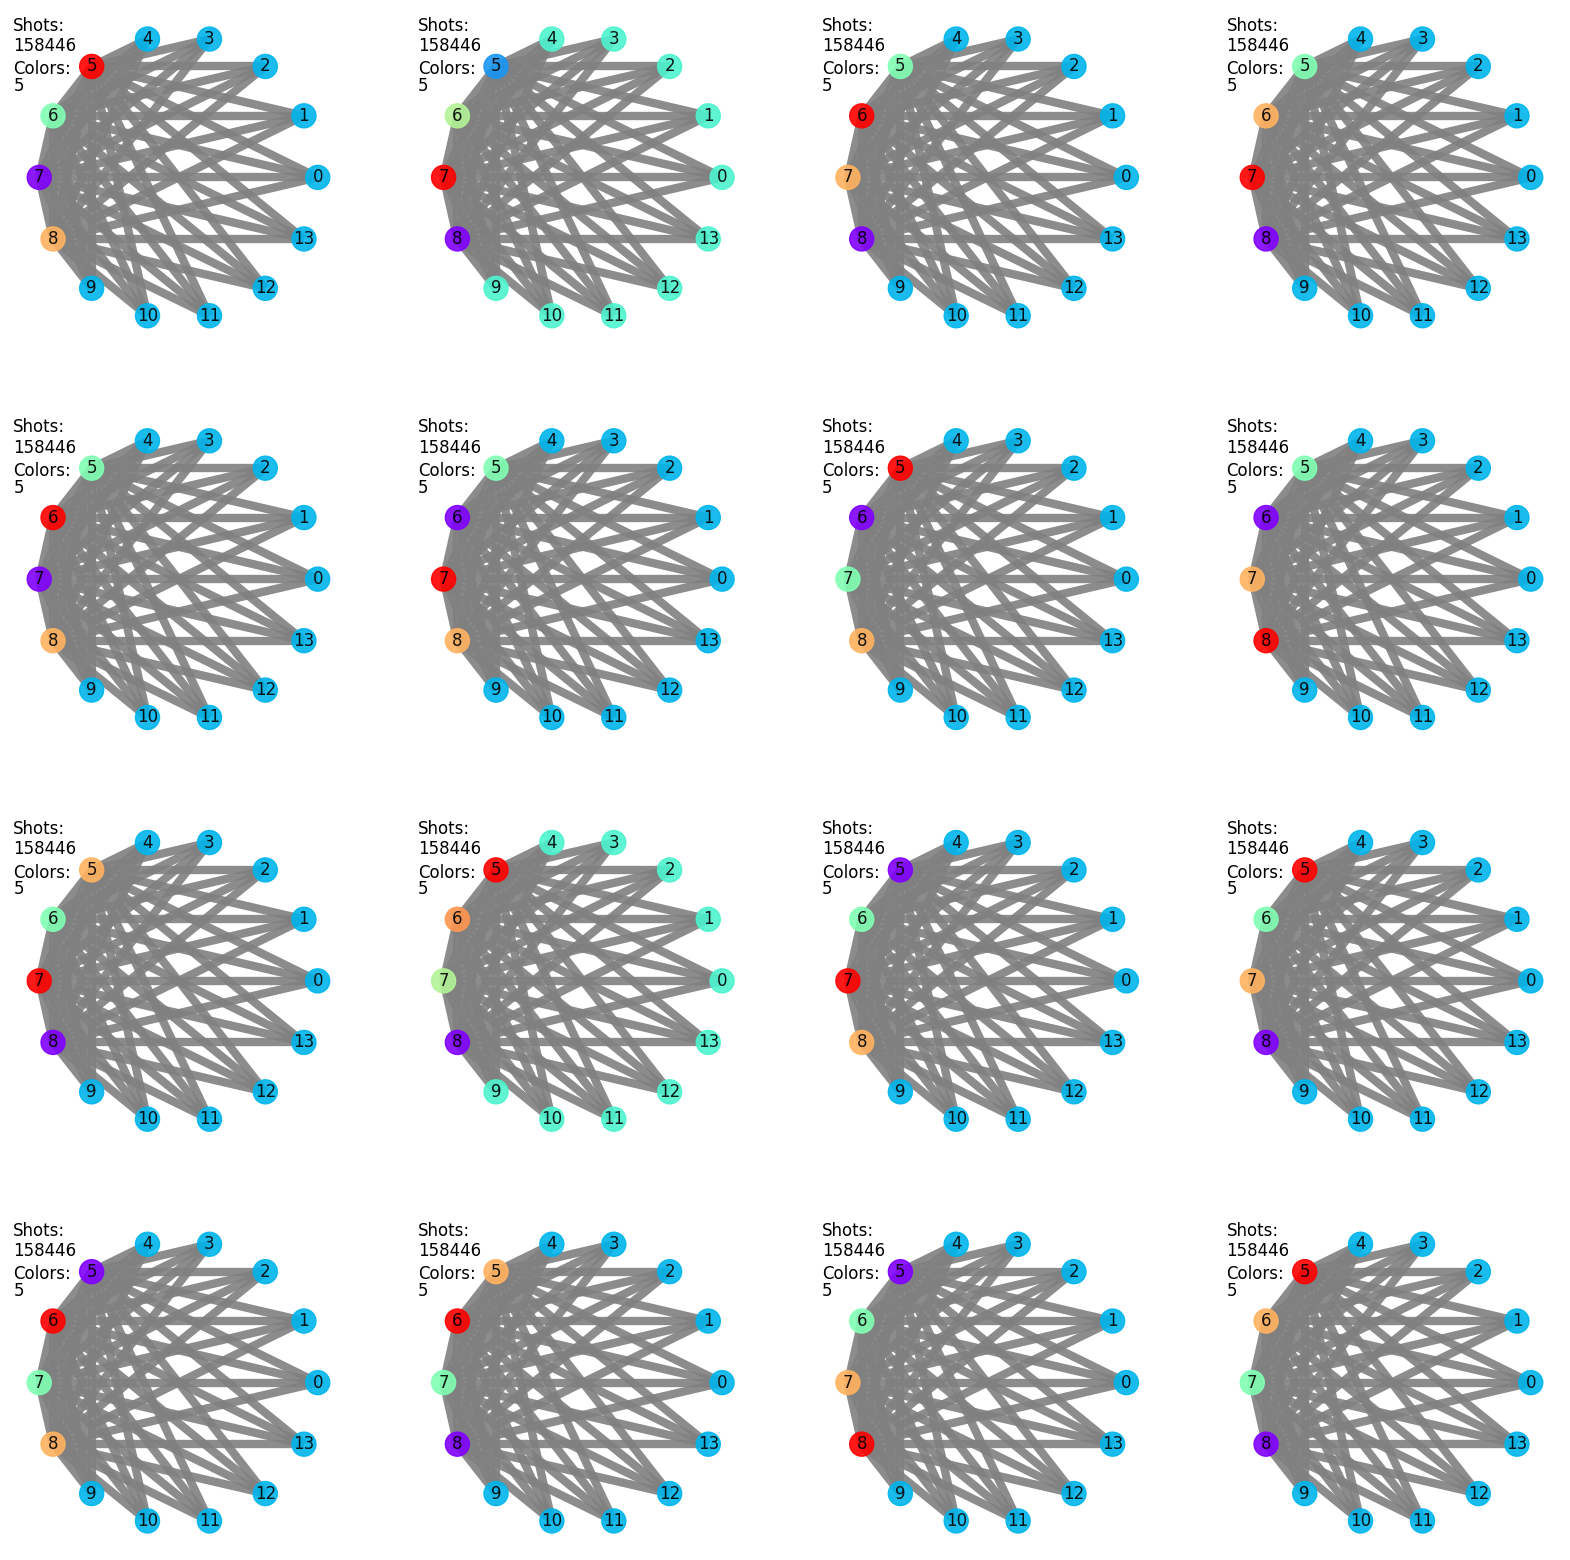

In [20]:
check_sampled_graphs_vqe_plot(fig_name, sampled_graphs_qwc)

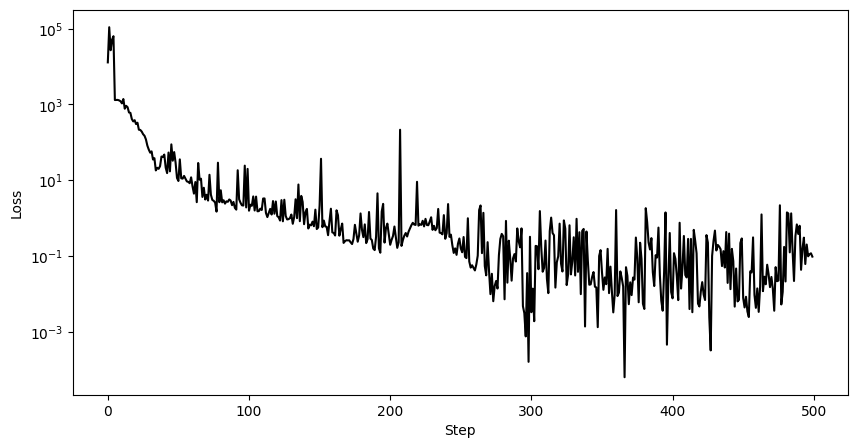

In [21]:
plot_loss_curve(fig_name, losses, title="Loss over Training Iterations")

Minimum number of groups found 5


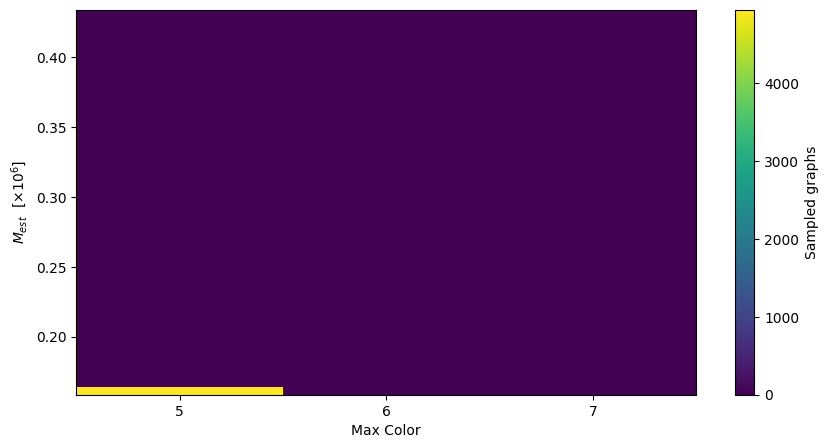

In [22]:
histogram_all(fig_name,sampled_graphs_qwc)

Now we repeat for **Fully Commuting**

Number of terms in the graph: 14
For all experiments, our hyperparameters will be:
    + n_hid_units=512
    + n_episodes=5000
    + learning_rate=0.005
    + update_freq=10


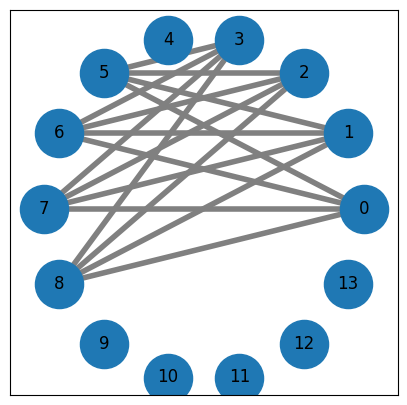

In [23]:
binary_H = BinaryHamiltonian.init_from_qubit_hamiltonian(H)
terms=get_terms(binary_H)
CompMatrix=FC_CompMatrix(terms)
#CompMatrix=QWC_CompMatrix(terms)
Gc=obj_to_comp_graph(terms, CompMatrix)
n_terms=nx.number_of_nodes(Gc)
print("Number of terms in the graph: {}".format(n_terms))
n_hid_units = 512
n_episodes = 5000
learning_rate = 5e-3 #5e-4 1e-3 try on your own
update_freq = 10
seed = 99
fig_name = "Test"

print("For all experiments, our hyperparameters will be:")
print("    + n_hid_units={}".format(n_hid_units))
print("    + n_episodes={}".format(n_episodes))
print("    + learning_rate={}".format(learning_rate))
print("    + update_freq={}".format(update_freq))

pos = nx.circular_layout(Gc)
options = {
    "pos": pos,
    "node_size": 1200,
    "edge_color": "gray",
    "alpha": 1,
    "width": 4,
    "labels": {n: n for n in Gc}
}
plt.figure(1,figsize=(5,5))
nx.draw_networkx(Gc,**options)

In [24]:
sampled_graphs, losses = TB_training(Gc, n_terms, n_hid_units, n_episodes, learning_rate, update_freq, seed, n_q)

Training iter: 100%|██████████| 5000/5000 [02:13<00:00, 37.50it/s]


Proportion of valid graphs:0.999, ideal=1
Number of unique graphs =1088
Number of shots for the best 16 graphs
Number of shots=113270, max color 2 and reward 20.82846296459786
Number of shots=113270, max color 2 and reward 20.82846296459786
Number of shots=127752, max color 2 and reward 19.82766610307471
Number of shots=127752, max color 2 and reward 19.82766610307471
Number of shots=128928, max color 3 and reward 18.75626706378754
Number of shots=128928, max color 3 and reward 18.75626706378754
Number of shots=128928, max color 3 and reward 18.75626706378754
Number of shots=128928, max color 3 and reward 18.75626706378754
Number of shots=131065, max color 3 and reward 18.629802006637927
Number of shots=131065, max color 3 and reward 18.629802006637927
Number of shots=131065, max color 3 and reward 18.629802006637927
Number of shots=131065, max color 3 and reward 18.629802006637927
Number of shots=137476, max color 2 and reward 19.273996915825307
Number of shots=138611, max color 2 and

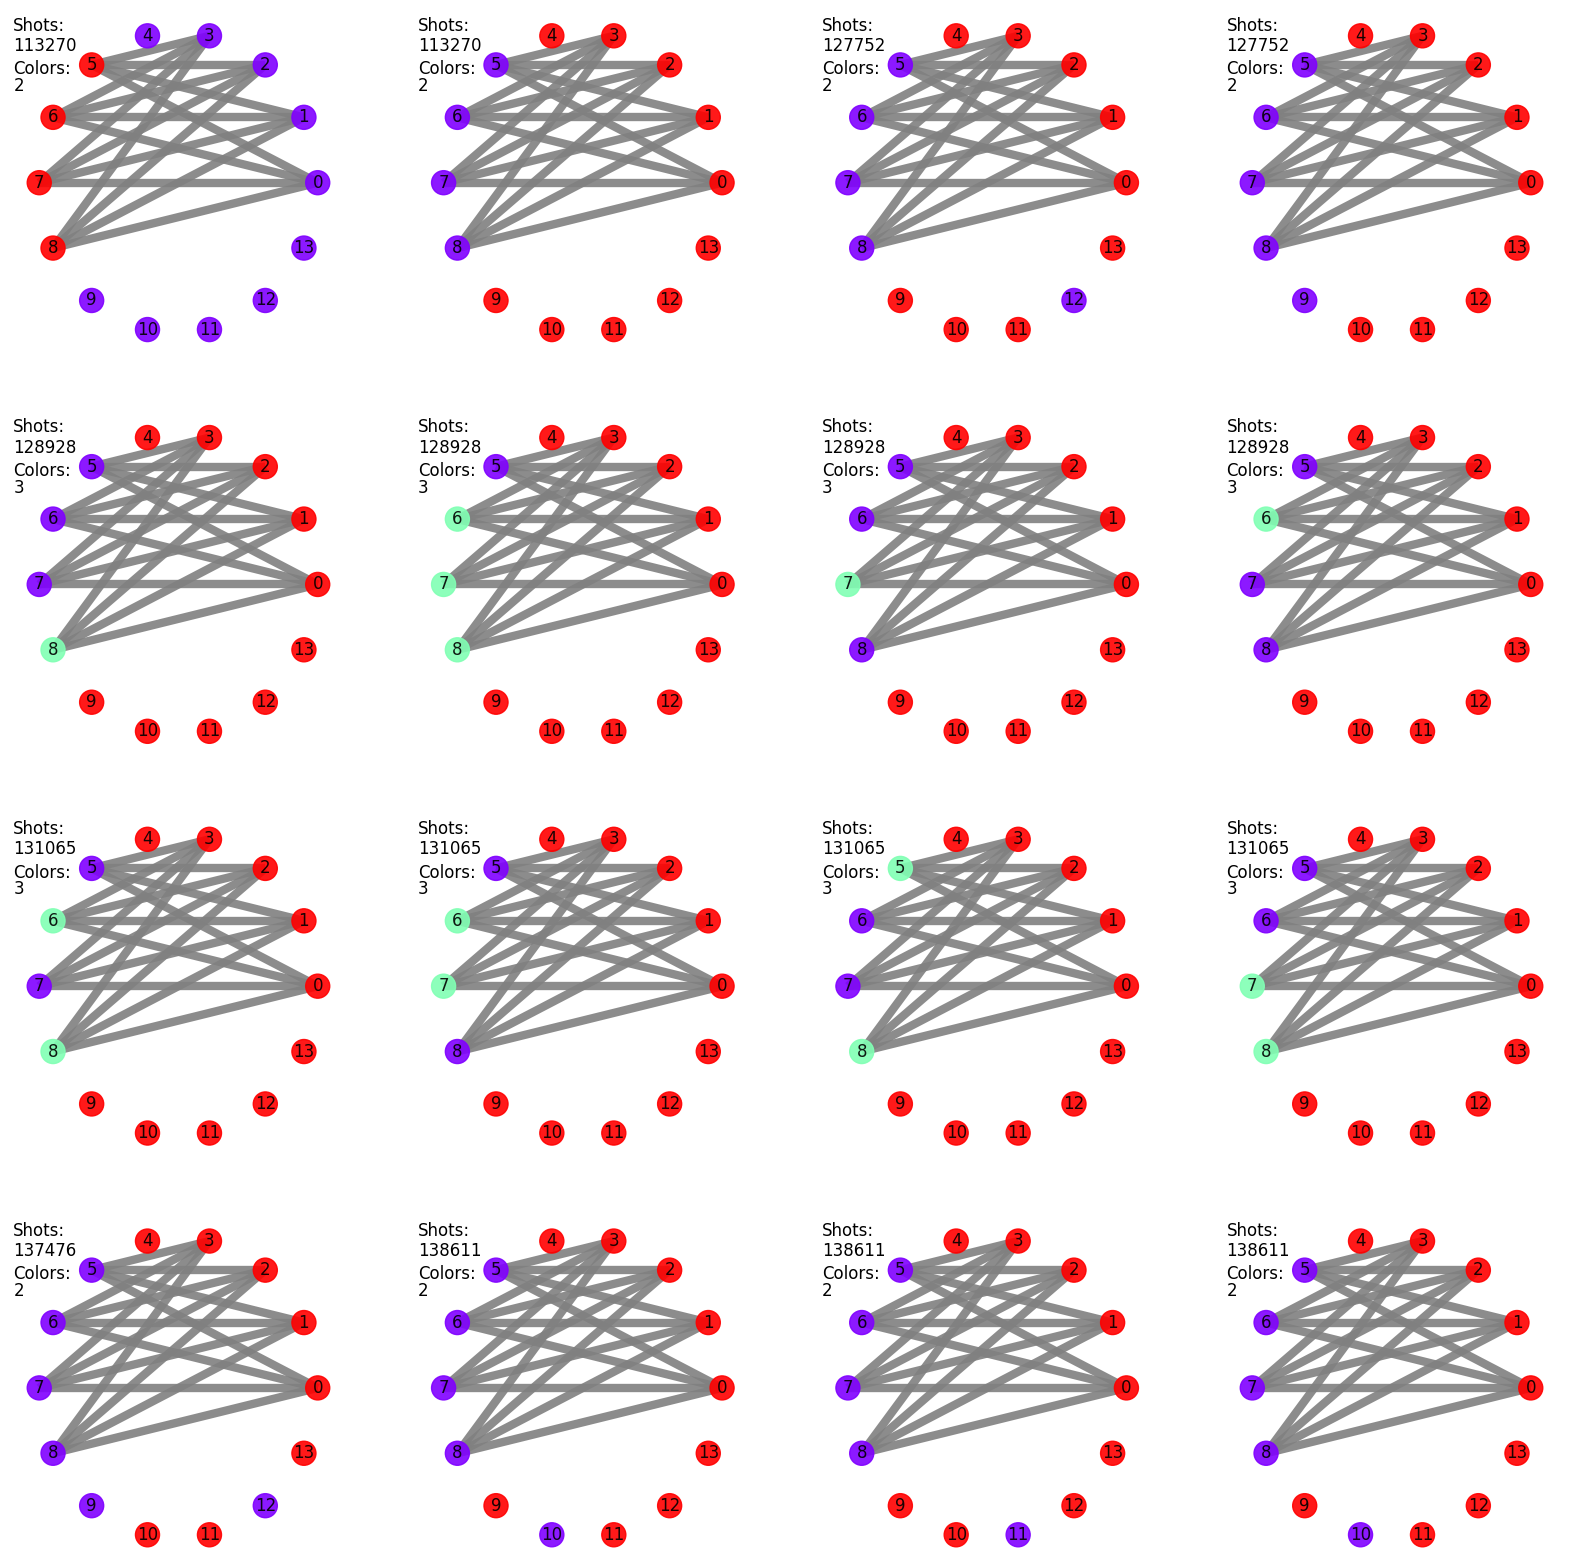

In [25]:
check_sampled_graphs_vqe_plot(fig_name, sampled_graphs)

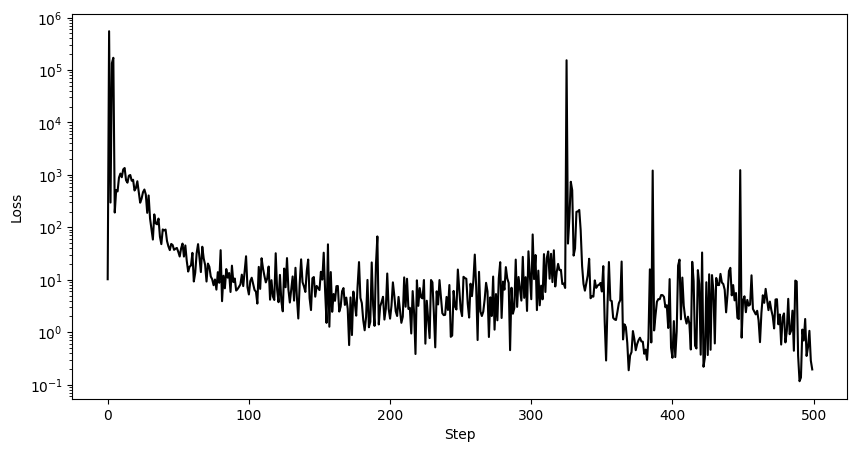

In [26]:
plot_loss_curve(fig_name, losses, title="Loss over Training Iterations")

Minimum number of groups found 2


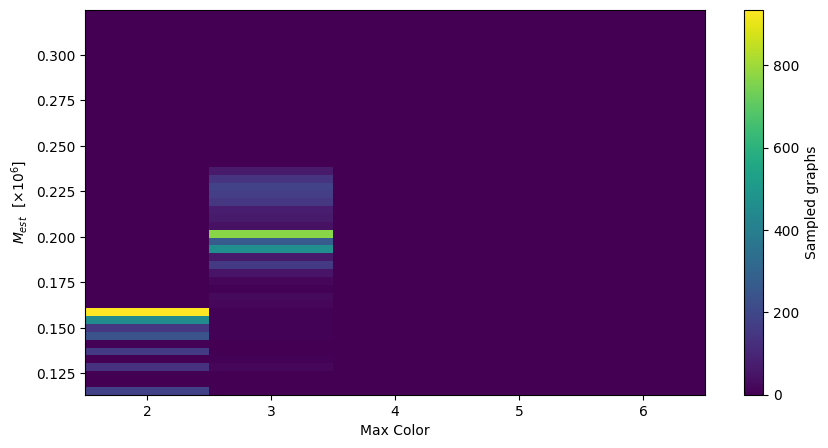

In [27]:
histogram_all(fig_name,sampled_graphs)

## Summary of Results
| Methods      | Num. of Measurments |
| ----------- | ----------- |
| No grouping     | 1414072      |
|   |       |
| RLF/FC | 163539 |
|  RLF/QWC | 329884 |
| GFlowNets/FC | 113270 |
| GFlowNets/QWC | 158446 |



#Lets see how to measure the energy from our graphs

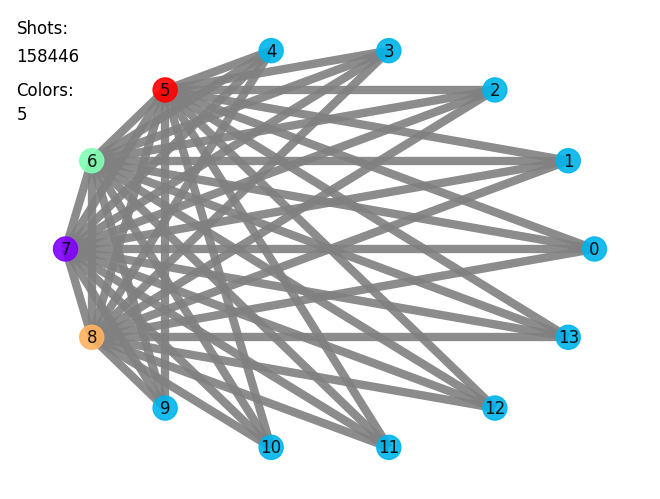

In [28]:
unique_graphs = []
seen_color_dicts = set()

for graph in sorted(sampled_graphs_qwc, key=lambda i: shots_estimator(i), reverse=False):
    color_dict = frozenset(nx.get_node_attributes(graph, "color").items())
    if color_dict not in seen_color_dicts:
        seen_color_dicts.add(color_dict)
        unique_graphs.append(graph)

plot_graph_wcolor(unique_graphs[0])

In [29]:
print(vqe_reward(unique_graphs[0]))
h_by_color = extract_hamiltonian_by_color(unique_graphs[0])
groups = generate_groups(h_by_color)
imported_operators = convert_operators(groups)

obs_groupings = []
c_groupings = []
H_group = []
for i in range(len(imported_operators)):
    coeffs, obs = imported_operators[i].terms()
    obs_groupings.append(obs)
    c_groupings.append(coeffs)
    H_group.append(qml.Hamiltonian(coeffs=coeffs, observables=obs))

rotations, circuits = qml.pauli.diagonalize_qwc_groupings(obs_groupings)
print(rotations)
print(circuits)
print("Number of circuits to run: {}".format(len(circuits)))

15.311298486550623
[[], [RX(1.5707963267948966, wires=[0]), RY(-1.5707963267948966, wires=[1]), RY(-1.5707963267948966, wires=[2]), RX(1.5707963267948966, wires=[3])], [RX(1.5707963267948966, wires=[0]), RX(1.5707963267948966, wires=[1]), RY(-1.5707963267948966, wires=[2]), RY(-1.5707963267948966, wires=[3])], [RY(-1.5707963267948966, wires=[0]), RY(-1.5707963267948966, wires=[1]), RX(1.5707963267948966, wires=[2]), RX(1.5707963267948966, wires=[3])], [RY(-1.5707963267948966, wires=[0]), RX(1.5707963267948966, wires=[1]), RX(1.5707963267948966, wires=[2]), RY(-1.5707963267948966, wires=[3])]]
[[Z(0), Z(1), Z(2), Z(3), Z(0) @ Z(1), Z(0) @ Z(2), Z(0) @ Z(3), Z(1) @ Z(2), Z(1) @ Z(3), Z(2) @ Z(3)], [Z(0) @ Z(1) @ Z(2) @ Z(3)], [Z(0) @ Z(1) @ Z(2) @ Z(3)], [Z(0) @ Z(1) @ Z(2) @ Z(3)], [Z(0) @ Z(1) @ Z(2) @ Z(3)]]
Number of circuits to run: 5


In [31]:
dev = qml.device("lightning.qubit", wires=4)
num_qubits = 4

@qml.qnode(dev, interface="jax")
def circuit(params, group=None, **kwargs):
    for w in range(num_qubits):
        qml.Hadamard(wires=w)
        qml.RY(params[w], wires=w)
    for w in dev.wires[:-1]:
        qml.CNOT(wires=[w, w + 1])
    for w in dev.wires:
        qml.RZ(params[w + num_qubits], wires=w)
    return [qml.expval(o) for o in group]

params = np.random.randn(2 * num_qubits)
result = [jnp.array(circuit(params, group=g)) for g in H_group]

print("Term expectation values:")
for group, expvals in enumerate(result):
    print(f"Group {group} expectation values:", expvals)

# Since all the coefficients of the Hamiltonian are unity,
# we can simply sum the expectation values.
print("<H> = ", jnp.sum(jnp.hstack(result)))

Term expectation values:
Group 0 expectation values: [ 0.08696918 -0.08543622 -0.05726049 -0.00061147 -0.15384032  0.07359097
  0.00114981 -0.10960495 -0.00079996  0.00174349]
Group 1 expectation values: [-0.00080944]
Group 2 expectation values: [-0.02952474]
Group 3 expectation values: [0.00145494]
Group 4 expectation values: [0.02694604]
<H> =  -0.24603316


Additional reference for advanced methods, to improve we need to approximate the variances:

[Advanced methods](https://github.com/tequilahub/tequila-tutorials-unformatted/tree/main/research/optimized-measurements)


## Homework: LiH
Due to time constrains, we can not do the same study for LiH. However, you can use the following code to generate the Hamiltonian for LiH. If the sampling on Colab is slow, reduce n_episodes to 1000.


```Python
def LiH():
    '''
    LiH hamiltonian.
    '''
    trafo = "JordanWigner"
    mol = tq.chemistry.Molecule(
                            geometry="Li 0.0 0.0 0.0 \n H 0.0 0.0 1.",
                            basis_set="sto3g",
                            transformation=trafo,
                            backend='pyscf'
                                 )
    H = mol.make_hamiltonian()
    Hq = H.to_openfermion()
    Hferm = reverse_jordan_wigner(Hq)
    # Minus 1 since it always contain a constant term that we don't need to measure.
    return mol, H, Hferm, len(Hq.terms) - 1, Hq
```

